In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit,minimize
%matplotlib inline
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
from matplotlib.gridspec import GridSpec

figaspectratio = 1.25

### Fixed Single Axis Rotation

In [2]:
def fixed_axis_lightcurve(theta,a,b,c):
    dist=np.abs(np.sin(theta)*np.tan(theta)*a**2+c**2*np.cos(theta))
    beta=np.sqrt(c**2+a**2*np.tan(theta)**2)

    return(np.pi*b*dist/beta)

def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))

def fixedHfunction(time,p,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(fixed_axis_lightcurve(beta-betainit,115,111,19))
    return(curve)

In [3]:
a,b,c=115,111,19

belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv")

beltime=belton['corrMMJD'].to_numpy()
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()

belton=np.array([beltime,belmag,belsig]).T

nbeltime=beltime[beltime<55.5]
nbelmag=belmag[beltime<55.5]
nbelsig=belsig[beltime<55.5]

In [4]:
fixedpopt,_=curve_fit(fixedHfunction,(nbeltime),nbelmag,p0=[7.36,1.7,33.25],
                    sigma=nbelsig,absolute_sigma=False,
                    bounds=([6,0,20],[8,2*np.pi,40]),maxfev=5000)

times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)
print(fixedpopt)
curve=fixedHfunction(times,*fixedpopt)

print(chi2(fixedHfunction(nbeltime,*fixedpopt),nbelmag,nbelsig))

[ 7.38873223  0.85020917 33.48776338]
32935.860618172344


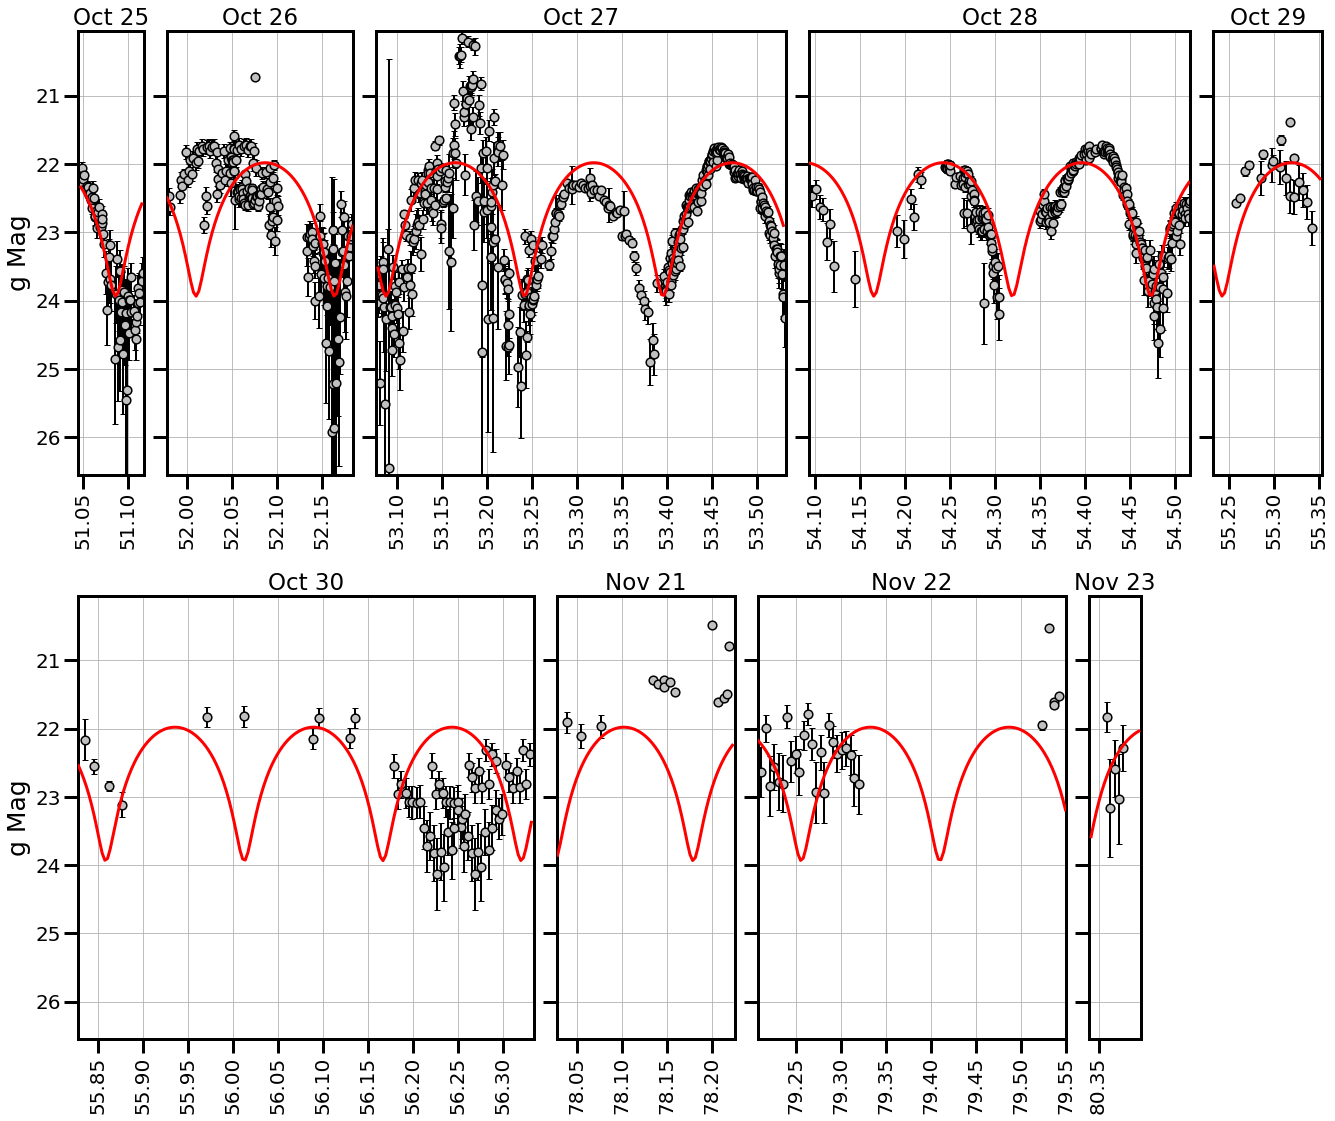

In [5]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique(beltime//1)-.25

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))

axspace=0.02
tickspace=0.05

yspace=0.06

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

axes=[]
for i in range(len(days)):
    xmin,xmax=limits[i]
    dx = (xmax-xmin)*platescale
    if i//5 == 0:
        ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
    else:
        ax=fig.add_axes([corner,0,dx,0.5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    ax.set_title(labels[i],fontsize=23)
    ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3)
    ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
    ax.plot(times[np.where((times<xmax)&(times>xmin))],
                 curve[np.where((times<xmax)&(times>xmin))],
                 color='r',zorder=3,lw=3)
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    
    if i==4: corner=0

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
fig.set_rasterized(True)
    
plt.savefig('../Figures and Paper/fixed_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=300)

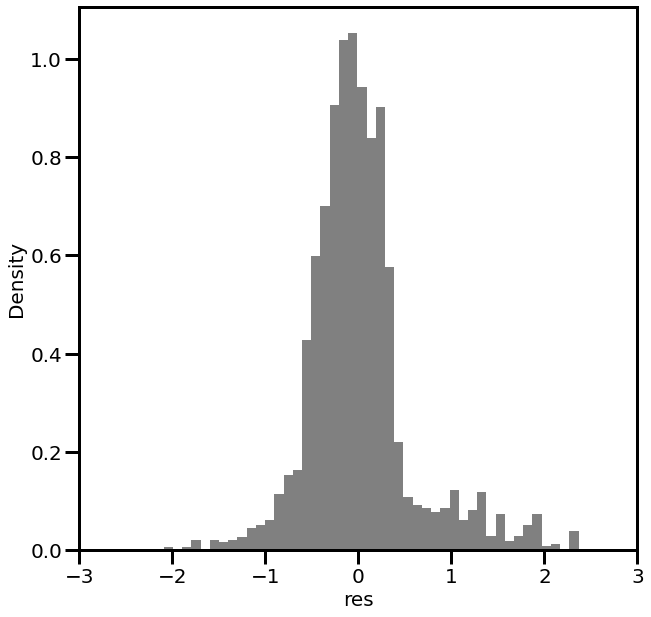

In [6]:
curve=fixedHfunction(beltime,*fixedpopt)

plt.figure(figsize=(10,10))
plt.hist(curve-belmag,bins=50,color='gray',density=True,weights=1/belsig,histtype='stepfilled')
plt.xlabel("res")
plt.ylabel("Density")
plt.xlim([-3,3])

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/fixed_axis_residual.pdf",
           bbox_inches='tight',dpi=300)

### Arbitrary Single Axis Rotation
Arbitrary rotation axis, numerical model.

In [7]:
import numpy as np
import scipy
import quaternion
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

def arbitrary_axis_lightcurve(theta,a,b,c,rot=[0,1,0],obs=[1,0,0],N=250):
    ndata=theta.size
    obs=np.quaternion(0,*obs)
    
    # Generate x,y points
    x=np.linspace(-a,a,N)
    y=np.linspace(-b,b,N)
    
    X,Y=np.meshgrid(x,y,indexing='ij')
    
    # Remove the points outside of bounds
    pts_in=np.where(X**2/a**2+Y**2/b**2<=1)
    X=X[pts_in]
    Y=Y[pts_in]
    
    # Generate z points for the x and y points
    z=c*np.sqrt(np.abs(1-X**2/a**2-Y**2/b**2))
    
    # Get +/- z points
    x=np.append(X,X)
    y=np.append(Y,Y)
    z=np.append(z,-z)
    
    npts=z.size
    
    # Combine points
    pts=np.array([x,y,z]).T
    pts=np.tile(pts[:,:,np.newaxis],ndata)
        
    rot=rot/np.sqrt(np.sum(np.square(rot)))
    nrot=np.outer(np.array(rot),np.sin(theta/2))
    nrot=np.append(np.cos(theta[np.newaxis,:]/2),nrot,axis=0)
    
    q=quaternion.as_quat_array(nrot.T)
    q*=1/np.abs(q)
    
    obs=np.conj(q)*obs*q
    obs=quaternion.as_float_array(obs)[:,1:]
    
    obs=np.repeat(obs.T[np.newaxis,:,:],npts,axis=0)
    
    inner=np.sum(pts*obs,axis=1)
    inner=np.repeat(inner[:,np.newaxis,:],3,axis=1)
    
    proj=pts-inner*obs
    proj=np.append(np.zeros((npts,ndata))[:,np.newaxis,:],proj,axis=1)    
    
    proj=np.moveaxis(proj,1,2)
    proj=quaternion.as_quat_array(proj)
    
    q=np.repeat(q[np.newaxis,:],npts,axis=0)
    
    proj=q*proj*np.conj(q)
    proj=quaternion.as_float_array(proj)
    proj=proj[:,:,2:]
    
    output=[]
    for i in tqdm(range(ndata),desc='Hull Loop',leave=True):
        hull=scipy.spatial.ConvexHull(proj[:,i,:])
        output.append(hull.volume)
        
    return(np.array(output))

def arbitraryHfunction(time,p,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    
    rot=[np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]
    curve=deltaV-2.5*np.log10(arbitrary_axis_lightcurve(beta-betainit,115,111,19,rot=rot,N=50))
    return(curve)

In [8]:
arbpopt,_=curve_fit(arbitraryHfunction,nbeltime,nbelmag,p0=[7.36,1.5,np.pi/2,1.7,33.25],
                    sigma=nbelsig,absolute_sigma=False,
                    bounds=([6,0,0,0,20],[8,np.pi/2,2*np.pi,2*np.pi,40]),maxfev=5000)

times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)
print(arbpopt)
curve=arbitraryHfunction(times,*arbpopt)

print(chi2(arbitraryHfunction(nbeltime,*arbpopt),nbelmag,nbelsig))

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

[ 7.39741947  1.48969586  2.26755416  0.88769488 33.09220188]


Hull Loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/1001 [00:00<?, ?it/s]

29800.273274740837


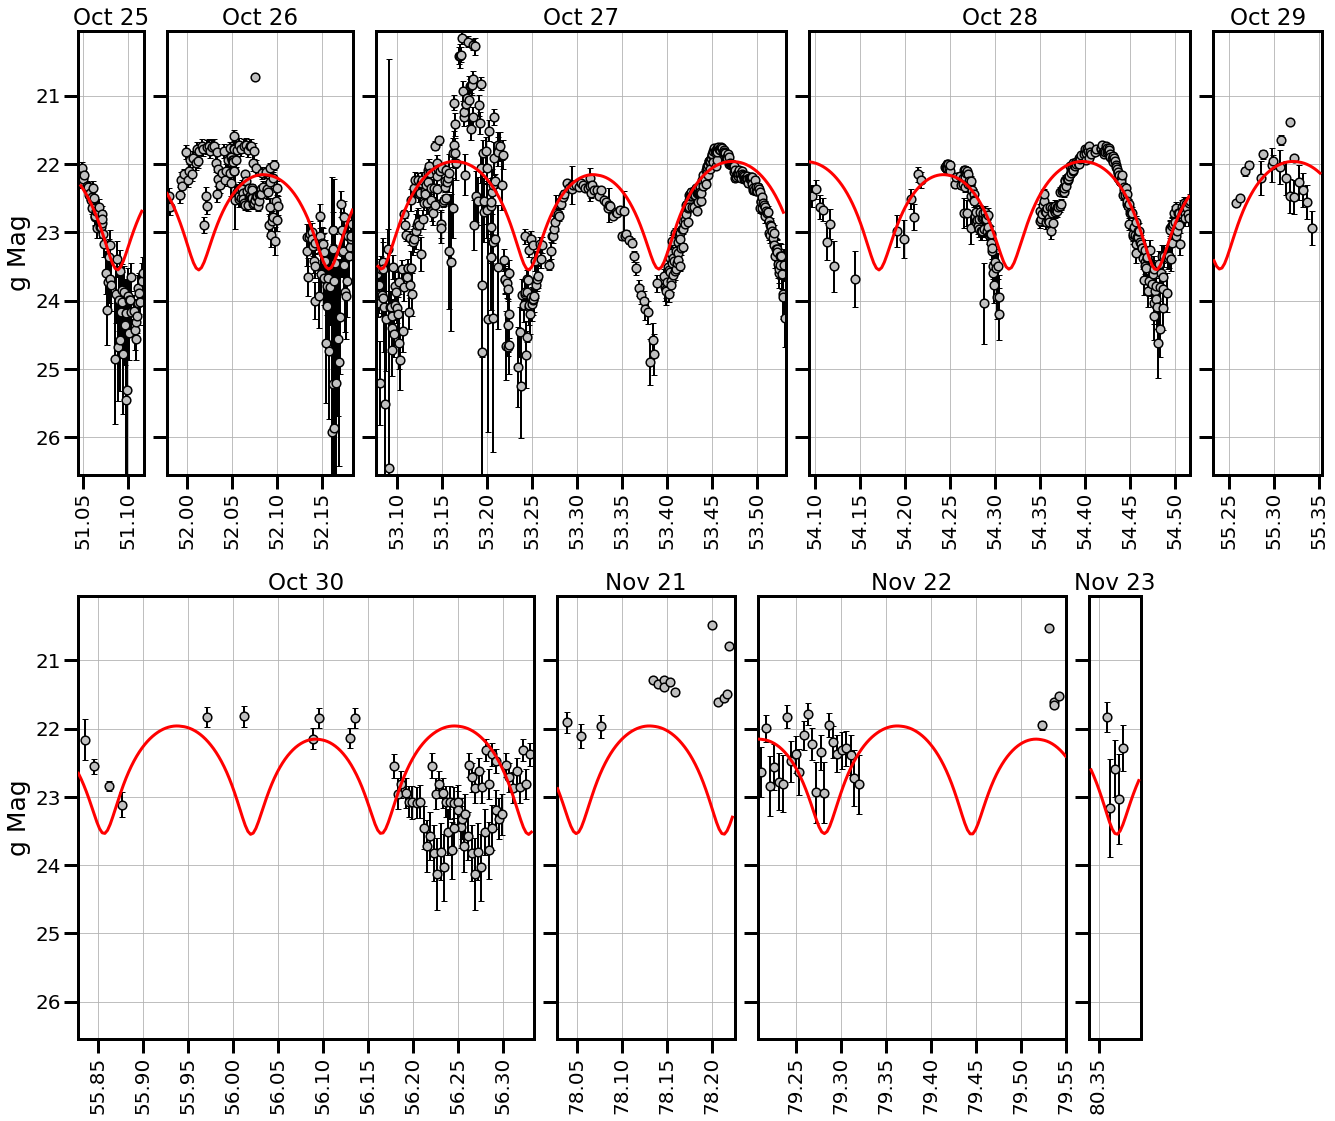

In [9]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique(beltime//1)-.25

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))

axspace=0.02
tickspace=0.05

yspace=0.06

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

axes=[]
for i in range(len(days)):
    xmin,xmax=limits[i]
    dx = (xmax-xmin)*platescale
    if i//5 == 0:
        ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
    else:
        ax=fig.add_axes([corner,0,dx,0.5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    ax.set_title(labels[i],fontsize=23)
    ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3)
    ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
    ax.plot(times[np.where((times<xmax)&(times>xmin))],
                 curve[np.where((times<xmax)&(times>xmin))],
                 color='r',zorder=3,lw=3)
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    
    if i==4: corner=0

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
fig.set_rasterized(True)
    
plt.savefig('../Figures and Paper/arbitrary_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=300)

Hull Loop:   0%|          | 0/1124 [00:00<?, ?it/s]

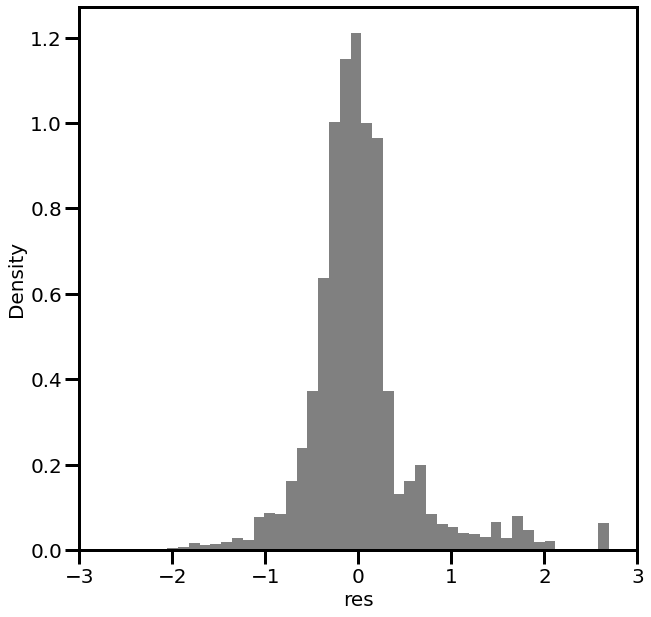

In [12]:
curve=arbitraryHfunction(beltime,*arbpopt)

plt.figure(figsize=(10,10))
plt.hist(curve-belmag,bins=50,color='gray',density=True,weights=1/belsig,histtype='stepfilled')
plt.xlabel("res")
plt.ylabel("Density")
plt.xlim([-3,3])

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/arbitrary_axis_residual.pdf",
           bbox_inches='tight',dpi=300)

Hull Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/500 [00:00<?, ?it/s]

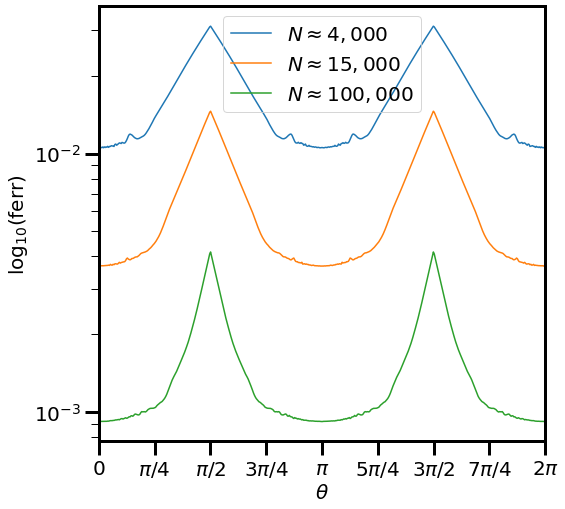

In [13]:
theta_data = np.linspace(0, 2*np.pi, 500)

simple = (fixed_axis_lightcurve(theta_data, 115, 111, 19))
light1 = (arbitrary_axis_lightcurve(theta_data, 115,111,19, N=50))
light2 = (arbitrary_axis_lightcurve(theta_data, 115,111,19, N=100))
light3 = (arbitrary_axis_lightcurve(theta_data, 115,111,19, N=250))

plt.figure(figsize=(8, 8))
#plt.plot(theta_data,simple)
plt.plot(theta_data, np.abs(light1-simple)/simple)
plt.plot(theta_data, np.abs(light2-simple)/simple)
plt.plot(theta_data, np.abs(light3-simple)/simple)
#plt.plot(theta_data,light3)
plt.yscale('log')
plt.legend(["$N\\approx 4,000$", "$N\\approx 15,000$", "$N\\approx 100,000$"])
plt.xticks(np.pi*np.linspace(0, 2, 9),
           labels=[0, "$\\pi/4$", "$\\pi/2$", "$3\\pi/4$", "$\\pi$",
                   "$5\\pi/4$", "$3\\pi/2$", "$7\\pi/4$", "$2\\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\\log_{10}(\mathrm{ferr})$")
plt.xlim([0,2*np.pi])

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/num_lightcurve_comp.pdf", bbox_inches='tight',
            dpi=300)

### Muinonen and Lumme 2015
An analytical model from M&L 2015

In [12]:
import numpy as np
import scipy
import quaternion as quat
import matplotlib.pyplot as plt
import pandas as pd

def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
        
    if isinstance(a,(np.floating,float,int)): a=a*np.ones_like(beta)
    else: a=a[None,:]

    if isinstance(b,(np.floating,float,int)): b=b*np.ones_like(beta)
    else: b=b[None,:]

    if isinstance(c,(np.floating,float,int)): c=c*np.ones_like(beta)
    else: c=c[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.einsum('ijk->jki',np.array([1/a**2,1/b**2,1/c**2]))
    Ts=np.sqrt(np.einsum('ijk,ijk,ijk->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,ijk->ij',obs,obs,C))

    cosa=np.einsum('ijk,ijk,ijk->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

Hull Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/100 [00:00<?, ?it/s]

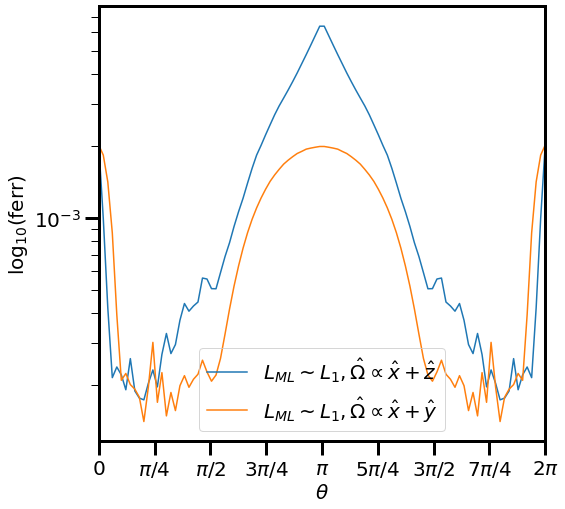

In [13]:
theta=[0]
phi=[np.pi/2]
psi=[0]

beta=np.linspace(0,2*np.pi,1000)[None,:]

ml=(evolving_axis_lightcurve(theta,phi,psi,115,111,19,np.zeros_like(beta),beta))[0,:]
simple=fixed_axis_lightcurve(beta[0,:],115,111,19)

plt.figure(figsize=(8,8))
#plt.plot(beta[0,:],np.abs((ml-simple)/simple))

theta=[0]
phi=[np.pi/4]
psi=[np.pi/2]
beta=np.linspace(0,2*np.pi,100)[None,:]

ml=(evolving_axis_lightcurve(theta,phi,psi,115,111,19,np.zeros_like(beta),beta))[0,:]
arb=arbitrary_axis_lightcurve(beta[0,:],115,111,19,rot=[1,0,1],obs=[1,0,0],N=150)

plt.plot(beta[0,:],np.abs((ml-arb)/arb))

theta=[0]
phi=[np.pi/4]
psi=[0]
beta=np.linspace(0,2*np.pi,100)[None,:]

ml=(evolving_axis_lightcurve(theta,phi,psi,115,19,111,np.zeros_like(beta),beta))[0,:]
arb=arbitrary_axis_lightcurve(beta[0,:],115,19,111,rot=[1,1,0],obs=[1,0,0],N=150)

plt.plot(beta[0,:],np.abs((ml-arb)/arb))
plt.yscale('log')

plt.legend([r"$L_{ML}\sim L_1, \hat{\Omega}\propto\hat{x}+\hat{z}$",
            r"$L_{ML}\sim L_1, \hat{\Omega}\propto\hat{x}+\hat{y}$"])
plt.xticks(np.pi*np.linspace(0, 2, 9),
           labels=[0, "$\\pi/4$", "$\\pi/2$", "$3\\pi/4$", "$\\pi$",
                   "$5\\pi/4$", "$3\\pi/2$", "$7\\pi/4$", "$2\\pi$"])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log_{10}(\mathrm{ferr})$")
plt.xlim([0,2*np.pi])

fig.set_rasterized(True)

plt.savefig('../Figures and Paper/ml_comp.pdf',
           bbox_inches='tight',dpi=300)

In [14]:
from scipy.interpolate import interp1d

belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv")

beltime=belton['corrMMJD'].to_numpy()
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()
belalpha=belton['aPh'].to_numpy()

belton=np.array([beltime,belmag,belsig]).T

octbeltime=beltime[beltime<55.5]
octbelmag=belmag[beltime<55.5]
octbelsig=belsig[beltime<55.5]

phase=pd.read_csv("../Lightcurves/Photometry/PhaseData.csv")
MJD=phase['MJD'].to_numpy()
datalpha=phase['Phase'].to_numpy()*np.pi/180

alpha=interp1d(MJD,datalpha,'linear')

In [15]:
def evolvingHfunction(time,p,theta,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,115,111,19,alpha(time),beta-betainit))[0,:]
    return(curve)

In [16]:
novbeltime=beltime[beltime>78]
novbelmag=belmag[beltime>78]
novbelsig=belsig[beltime>78]

In [17]:
per=np.linspace(6,8,5)
theta=np.linspace(0,2*np.pi,5)
phi=np.linspace(0,np.pi/2,5)
psi=np.linspace(0,2*np.pi,5)
betinit=np.linspace(0,2*np.pi,5)
deltaV=[32]

PER,THET,PHI,PSI,BETI,DELTAV=np.meshgrid(per,theta,phi,psi,betinit,deltaV,indexing='ij')
PER=PER.flatten()
THET=THET.flatten()
PHI=PHI.flatten()
PSI=PSI.flatten()
BETI=BETI.flatten()
DELTAV=DELTAV.flatten()

chimin=1e25
chilist=[]

poct=[]
pnov=[]

dpoct=[]
dpnov=[]
for i in tqdm(range(PER.size)):
    try:
        evopopt,evopcov=curve_fit(evolvingHfunction,octbeltime,octbelmag,p0=[PER[i],THET[i],PHI[i],PSI[i],BETI[i],DELTAV[i]],
                            sigma=octbelsig,absolute_sigma=True,
                            bounds=([6,0,0,0,0,20],[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,40]),maxfev=500)

        chitest=chi2(evolvingHfunction(octbeltime,*evopopt),octbelmag,octbelsig)
        if chitest<chimin:
            chimin=chitest
            metaopt=evopopt
            metacov=evopcov

        popt,thetaopt,phiopt,psiopt,biopt,delVopt=evopopt
        biopt=2*np.pi*((np.min(novbeltime)-np.min(octbeltime))%popt)/popt

        novpopt,novpcov=curve_fit(lambda time,p,bi,delV: evolvingHfunction(time,p,thetaopt,phiopt,psiopt,bi,delV),
                                  novbeltime,novbelmag,
                                  sigma=novbelsig,absolute_sigma=True,
                                  bounds=([6,0,20],[8,2*np.pi,40]),maxfev=1000)

        if chitest<30000:
            chilist.append(chitest)
            poct.append(evopopt[0])
            dpoct.append(np.sqrt(evopcov[0,0]))
            pnov.append(novpopt[0])
            dpnov.append(np.sqrt(novpcov[0,0]))
    except: pass
    
print(chimin)
print(metaopt)
print(np.sqrt(np.diag(metacov)))

  0%|          | 0/3125 [00:00<?, ?it/s]

27275.419549794016
[ 7.40067955  4.75927158  1.4227988   1.24751296  4.35445932 32.18106717]
[0.00112007 0.0168959  0.00157432 0.00409786 0.0100687  0.01378032]


In [18]:
times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)
curve=evolvingHfunction(times,*metaopt)

print(chi2(evolvingHfunction(octbeltime,*metaopt),octbelmag,octbelsig))

27275.419549794016


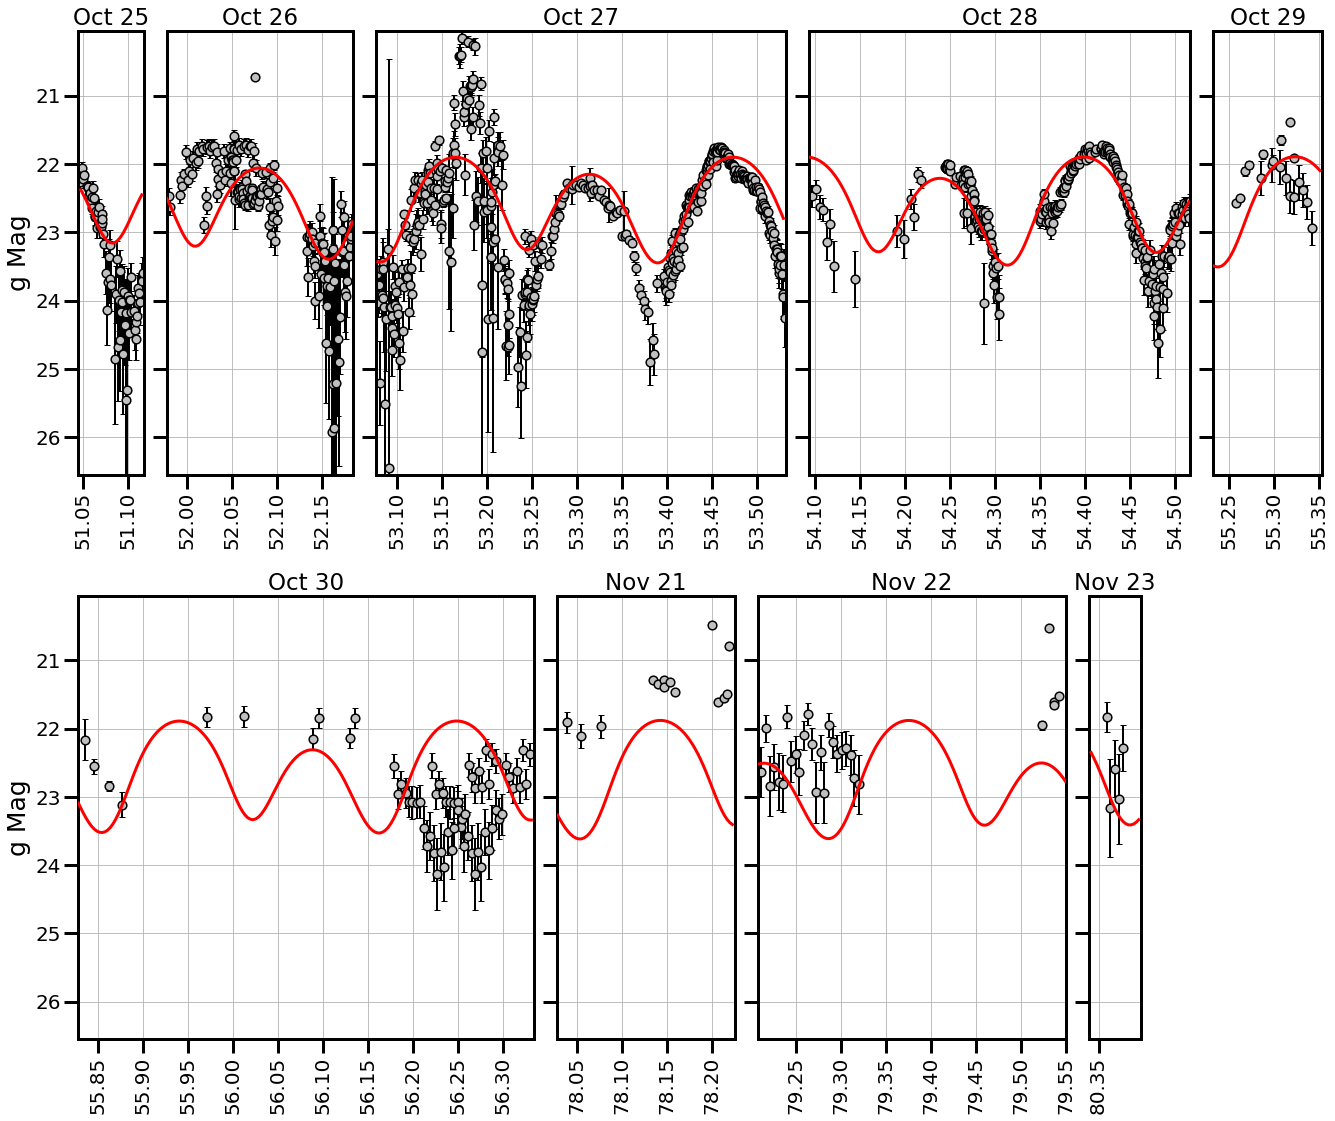

In [19]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique(beltime//1)-.25

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))

axspace=0.02
tickspace=0.05

yspace=0.06

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

axes=[]
for i in range(len(days)):
    xmin,xmax=limits[i]
    dx = (xmax-xmin)*platescale
    if i//5 == 0:
        ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
    else:
        ax=fig.add_axes([corner,0,dx,0.5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    ax.set_title(labels[i],fontsize=23)
    ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3)
    ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
    ax.plot(times[np.where((times<xmax)&(times>xmin))],
                 curve[np.where((times<xmax)&(times>xmin))],
                 color='r',zorder=3,lw=3)
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    
    if i==4: corner=0

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
fig.set_rasterized(True)
    
plt.savefig('../Figures and Paper/evolving_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=300)

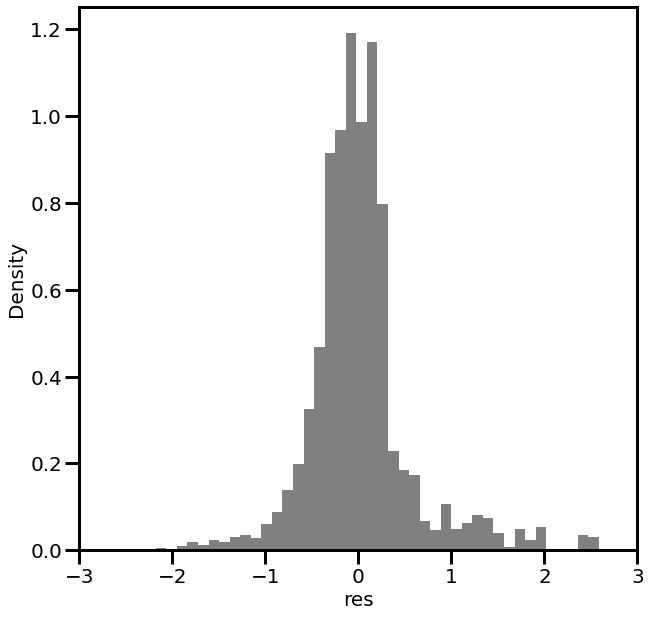

In [20]:
curve=evolvingHfunction(beltime,*metaopt)
plt.figure(figsize=(10,10))
plt.hist(curve-belmag,bins=50,color='gray',density=True,weights=1/belsig,histtype='stepfilled')
plt.xlabel("res")
plt.ylabel("Density")
plt.xlim([-3,3])

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/evolving_axis_residual.pdf",
           bbox_inches='tight',dpi=300)

In [21]:
print(np.cos(metaopt[2]))
print(np.sin(metaopt[2])*np.cos(metaopt[3]))
print(np.sin(metaopt[2])*np.sin(metaopt[3]))

0.14745784185609484
0.3142087638979027
0.9378320945483231


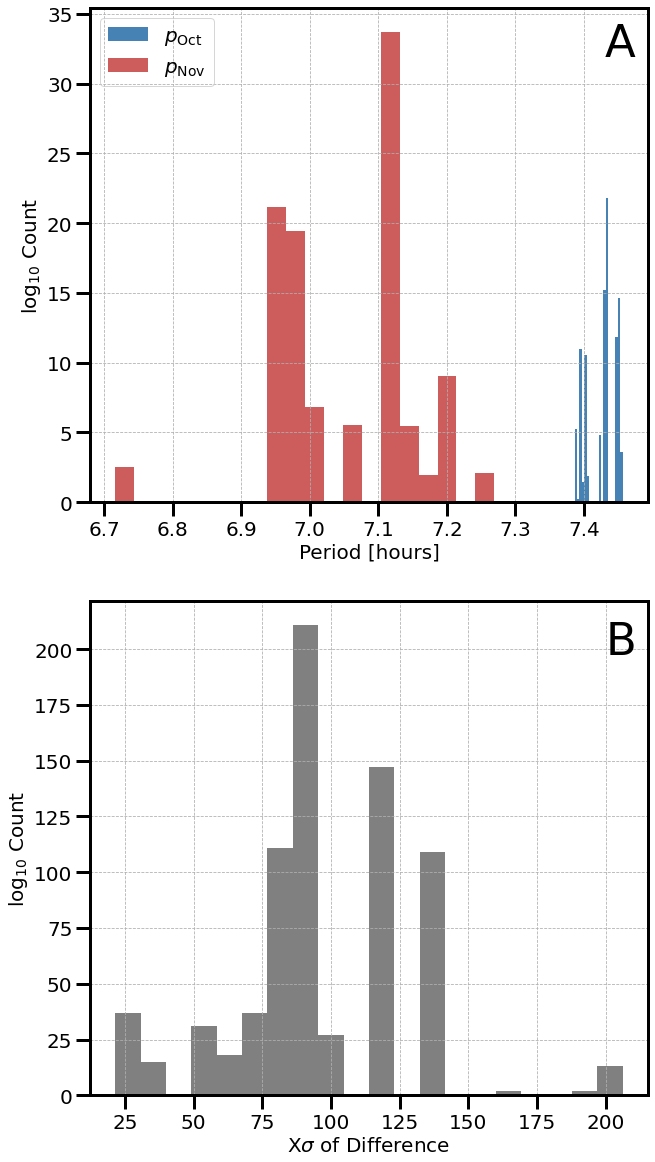

In [22]:
import matplotlib.ticker as ticker
import matplotlib.colors as colors

poct=np.array(poct)
pnov=np.array(pnov)

dpoct=np.array(dpoct)
dpnov=np.array(dpnov)

fig, axs = plt.subplots(2,1,figsize=(10,20))

axs[0].hist(poct,bins=20,density=False,weights=1/poct,color='steelblue',
            alpha=1,histtype='stepfilled',log=False,lw=4,label="$p_\\mathrm{Oct}$")
axs[0].hist(pnov,bins=20,density=False,weights=1/pnov,color='indianred',
            alpha=1,histtype='stepfilled',log=False,lw=4,label="$p_\\mathrm{Nov}$")
axs[0].legend(loc='upper left')
axs[0].grid(linestyle='dashed')
axs[0].set_xlabel("Period [hours]")
axs[0].set_ylabel("$\\log_{10}$ Count")
axs[0].text(7.43,32,"A",fontsize=45)

sigdiff=np.abs(poct-pnov)/np.sqrt(dpoct**2+dpnov**2)
axs[1].hist(sigdiff,bins=20,density=False,color='gray',
            histtype='stepfilled',log=False)
axs[1].set_xlabel("X$\\sigma$ of Difference")
axs[1].set_ylabel("$\\log_{10}$ Count")
axs[1].grid(linestyle='dashed')
axs[1].text(200,198,"B",fontsize=45)

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/period_comp_hist.pdf",
           bbox_inches='tight',dpi=300)

In [23]:
print(np.median(sigdiff))
print(np.min(sigdiff))
print(np.max(sigdiff))

print(sigdiff[np.where(chilist==np.min(chilist))])

print(pnov[np.where(chilist==np.min(chilist))])

93.2742068863233
21.46874725548267
206.1299419396571
[21.46944612]
[7.20050796]


3.998410986681184e-122
0.18685732077201808


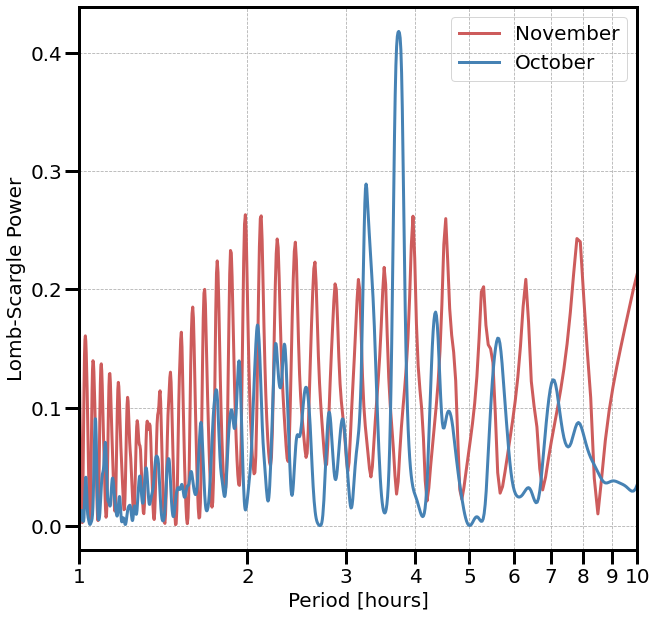

In [34]:
from astropy.timeseries import LombScargle
import astropy.units as u

octbeltime=beltime[beltime<78]
octbelmag=belmag[beltime<78]
octbelsig=belsig[beltime<78]

lsoct = LombScargle(octbeltime*24,octbelmag,octbelsig)
lsnov = LombScargle(novbeltime*24,novbelmag,novbelsig)

freqoct,powoct=lsoct.autopower(minimum_frequency=1/10,maximum_frequency=1,samples_per_peak=10)
freqnov,pownov=lsnov.autopower(minimum_frequency=1/10,maximum_frequency=1,samples_per_peak=10)

print(lsoct.false_alarm_probability(powoct.max()))
print(lsnov.false_alarm_probability(pownov.max()))

plt.figure(figsize=(10,10))
plt.plot(1/freqnov,pownov,alpha=1,color='indianred',lw=3,label='November')
plt.plot(1/freqoct,powoct,alpha=1,color='steelblue',lw=3,label='October')
plt.xlabel("Period [hours]")
plt.ylabel("Lomb-Scargle Power")
plt.xscale('log')
plt.legend()
plt.xticks(np.arange(1,11))
plt.grid(linestyle='dashed')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f'))
plt.xlim([1,10])

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/lomb_scargle_power.pdf",
           bbox_inches='tight',dpi=300)

7.400679554948484
[ 7.20050796  2.18500008 31.00311327]
[0.00925603 0.00984044 0.0079084 ]


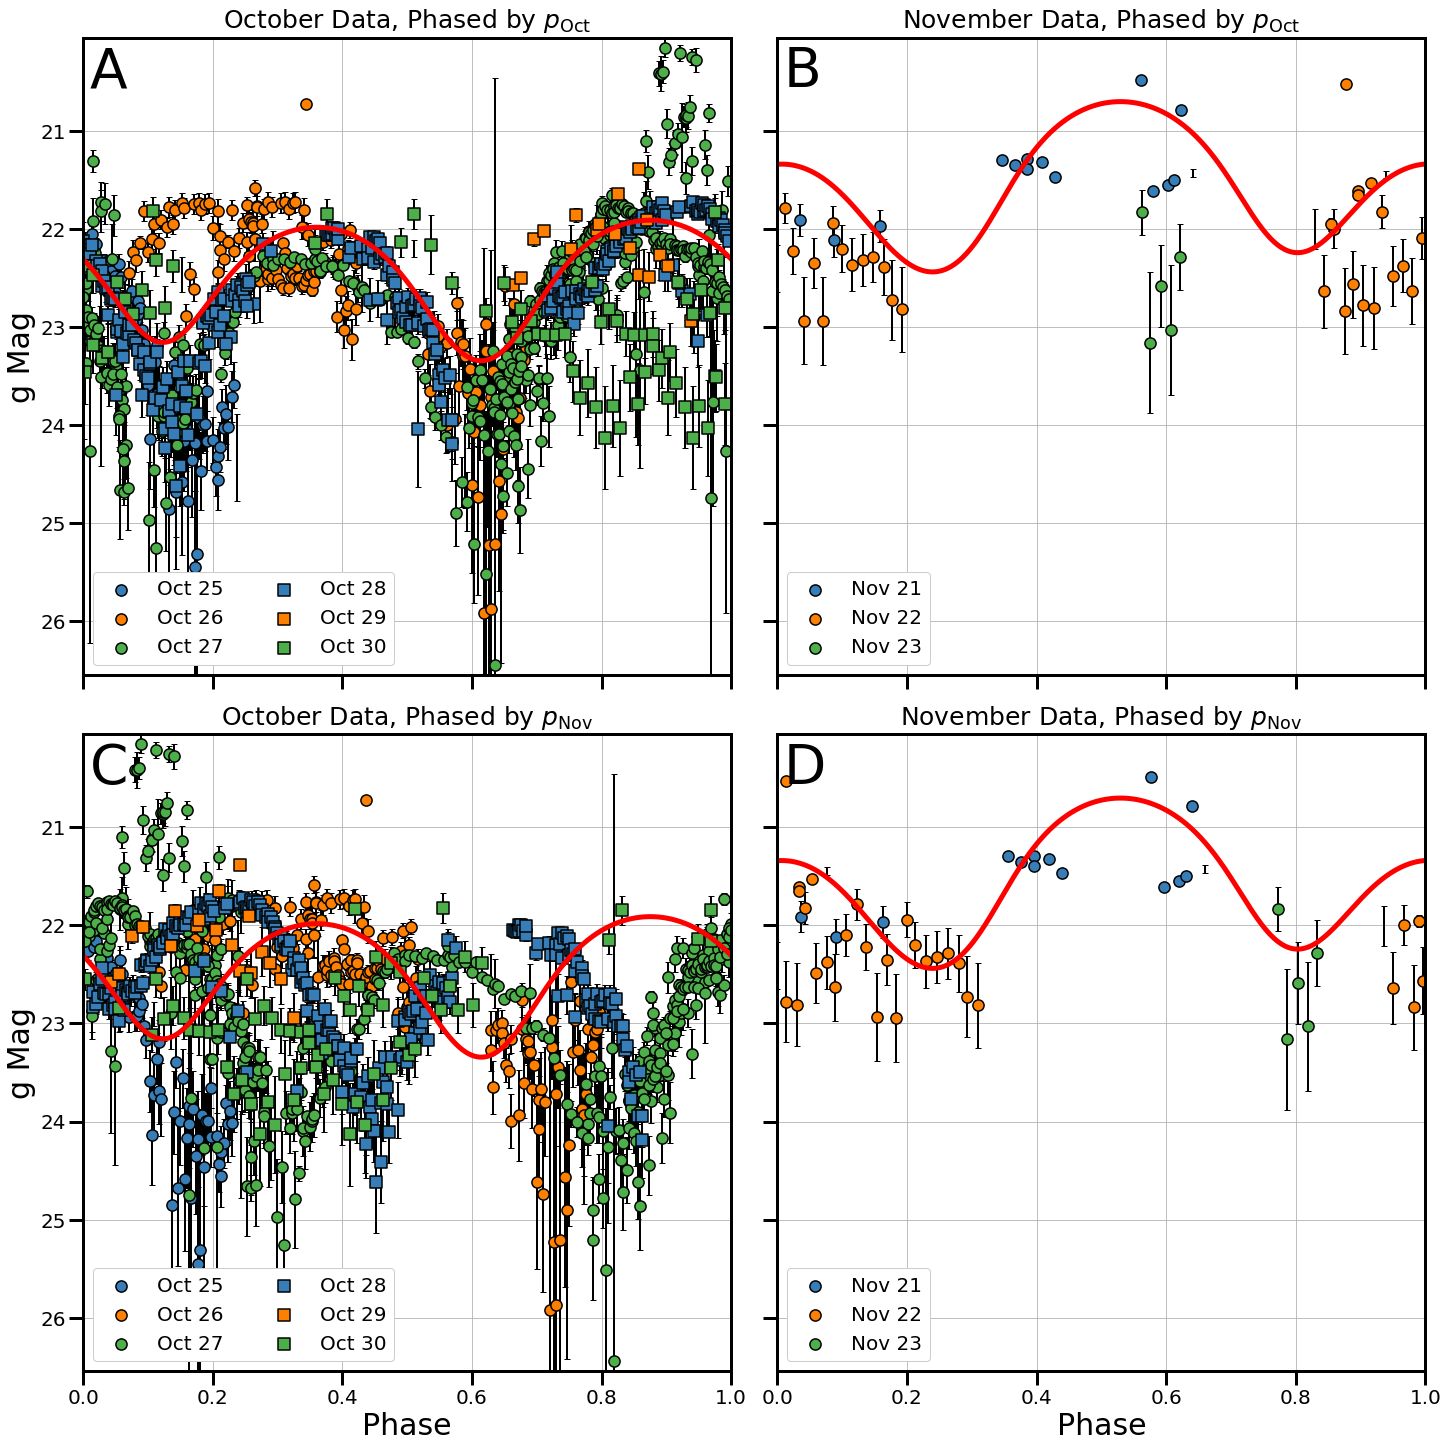

In [47]:
import matplotlib

octlabels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30']
novlabels=['Nov 21','Nov 22','Nov 23']
octdays=np.unique(octbeltime//1)-.25
novdays=np.unique(novbeltime//1)-.25

octlimits=[]
for d in octdays:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    octlimits.append((xmin,xmax))
    
novlimits=[]
for d in novdays:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    novlimits.append((xmin,xmax))

popt,thetaopt,phiopt,psiopt,biopt,delVopt=metaopt
biopt=2*np.pi*((np.min(novbeltime)-np.min(octbeltime))%popt)/popt

novpopt,novpcov=curve_fit(lambda time,p,bi,delV: evolvingHfunction(time,p,thetaopt,phiopt,psiopt,bi,delV),
                          novbeltime,novbelmag,
                          sigma=novbelsig,absolute_sigma=True,
                          bounds=([6,0,20],[8,2*np.pi,40]),maxfev=5000)

cols=np.tile(['#377eb8', '#ff7f00', '#4daf4a'],3)
shapes=np.repeat(['o','s','v'],3,axis=0)
sizes=np.repeat([125,125,175,325],3,axis=0)

print(popt)
print(novpopt)
print(np.sqrt(np.diag(novpcov)))
novpopt=np.append(novpopt,delVopt)

poct=popt/24
pnov=novpopt[0]/24

fig,axes=plt.subplots(2,2,figsize=(20,20),constrained_layout=True,sharex=True,sharey=True)
axes=axes.flatten()

ymax,ymin=np.max(belmag)+0.1,np.min(belmag)-0.1
axes[0].set_ylim([ymax,ymin])
axes[0].set_xlim([0,1])

octtime=np.linspace(np.min(octbeltime),np.min(octbeltime)+poct,10000,endpoint=False)
octcurve=evolvingHfunction(octtime,*metaopt)
octphase=(((octbeltime-np.min(octbeltime))%(poct)/poct))

uni,datcolors=np.unique(np.int32((octbeltime-np.min(octbeltime))//poct),return_inverse=True)

ax=axes[0]
ax.errorbar(octphase,octbelmag,yerr=octbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3)
for i in range(len(octlabels)):
    xmin,xmax=octlimits[i]
    inds=(octbeltime>xmin)&(octbeltime<xmax)
    ax.scatter(octphase[inds],octbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=octlabels[i],zorder=2)
ax.plot((((octtime-np.min(octtime))%(poct))/poct),octcurve,c='r',lw=5)
ax.set_title(r"October Data, Phased by $p_\mathrm{Oct}$", fontsize=25, pad=10)
ax.set_ylabel("g Mag",fontsize=30)
ax.legend(loc='lower left',ncol=2,framealpha=1,facecolor='white')
          
novtime=np.linspace(np.min(novbeltime),np.min(novbeltime)+poct,10000,endpoint=False)
novcurve=evolvingHfunction(novtime,poct*24,thetaopt,phiopt,psiopt,novpopt[1],novpopt[2])
novphase=(((novbeltime-np.min(novbeltime))%(poct)/poct))

ax=axes[1]
ax.errorbar(novphase,novbelmag,yerr=novbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3)
for i in range(len(novlabels)):
    xmin,xmax=novlimits[i]
    inds=(novbeltime>xmin)&(novbeltime<xmax)
    ax.scatter(novphase[inds],novbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=novlabels[i],zorder=2)
ax.plot((((novtime-np.min(novtime))%(poct))/poct),novcurve,c='r',lw=5)
ax.set_title(r"November Data, Phased by $p_\mathrm{Oct}$", fontsize=25, pad=10)
ax.legend(loc='lower left',framealpha=1,facecolor='white')
          
octtime=np.linspace(np.min(octbeltime),np.min(octbeltime)+pnov,10000,endpoint=False)
octcurve=evolvingHfunction(octtime,pnov*24,*metaopt[1:])
octphase=(((octbeltime-np.min(octbeltime))%(pnov)/pnov))

ax=axes[2]
ax.errorbar(octphase,octbelmag,yerr=octbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3)
for i in range(len(octlabels)):
    xmin,xmax=octlimits[i]
    inds=(octbeltime>xmin)&(octbeltime<xmax)
    ax.scatter(octphase[inds],octbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=octlabels[i],zorder=2)
ax.plot((((octtime-np.min(octtime))%(pnov))/pnov),octcurve,c='r',lw=5)
ax.set_title(r"October Data, Phased by $p_\mathrm{Nov}$", fontsize=25, pad=10)
ax.set_xlabel("Phase",fontsize=30)
ax.set_ylabel("g Mag",fontsize=30)
ax.legend(loc='lower left',ncol=2,framealpha=1,facecolor='white')
          
novtime=np.linspace(np.min(novbeltime),np.min(novbeltime)+pnov,10000,endpoint=False)
novcurve=evolvingHfunction(novtime,pnov*24,thetaopt,phiopt,psiopt,novpopt[1],novpopt[2])
novphase=(((novbeltime-np.min(novbeltime))%(pnov)/pnov))

ax=axes[3]
ax.errorbar(novphase,novbelmag,yerr=novbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3)
for i in range(len(novlabels)):
    xmin,xmax=novlimits[i]
    inds=(novbeltime>xmin)&(novbeltime<xmax)
    ax.scatter(novphase[inds],novbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=novlabels[i],zorder=2)
ax.plot((((novtime-np.min(novtime))%(pnov))/pnov),novcurve,c='r',lw=5)
ax.set_title(r"November Data, Phased by $p_\mathrm{Nov}$",fontsize=25, pad=10)
ax.set_xlabel("Phase",fontsize=30)
ax.legend(loc='lower left', framealpha=1,facecolor='white')

labels="ABCD"
for i,ax in enumerate(axes):
    ax.grid()
    ax.text(0.01,20.55,labels[i],fontsize=55) 

fig.set_rasterized(True)
    
plt.savefig("../Figures and Paper/phased_lightcurve.pdf",
           bbox_inches='tight',dpi=300)

In [27]:
def testHfunction(time,p,theta,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time)%p)/p
    alpha=15+time/3
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,115,111,19,alpha,beta-betainit))[0,:]
    return(curve)

True Values: 6.572528354910064 1.4383080077665429 0.22085844875529995 2.2892687149170285 1.342307639343037 34.79039244375343
Fit Values: 6.57200794397747 1.4397436846652836 0.22111790812444257 2.2903540868838523 1.3439161293841515 34.789292215367425
Fit STD: 0.000508377250037928 0.0020268745489214657 0.0004679553818170222 0.001245401756920018 0.0018902162753816343 0.002117523942679537
Maximum Error: 0.008839150833281906


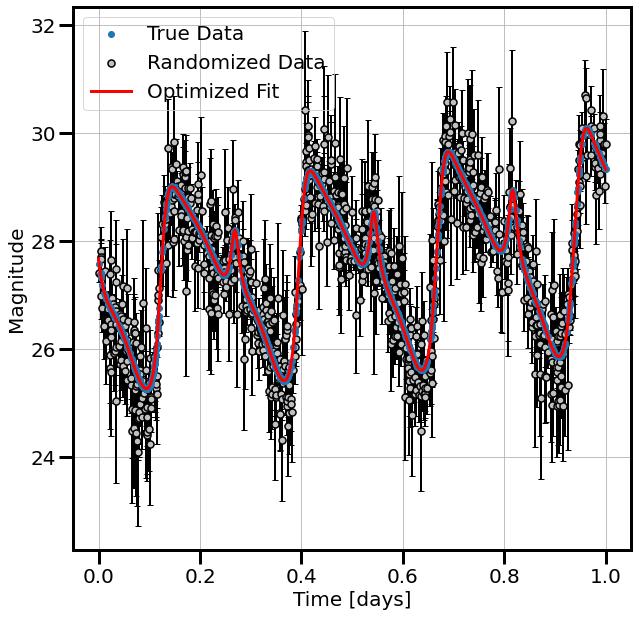

In [28]:
np.random.seed(523903213)

prand=np.random.uniform(6,8)/24
thetarand=np.random.uniform(0,2*np.pi)
phirand=np.random.uniform(0,np.pi/2)
psirand=np.random.uniform(0,2*np.pi)
betairand=np.random.uniform(0,2*np.pi)
delVrand=np.random.uniform(30,35)
print("True Values:", prand*24,thetarand,phirand,psirand,betairand,delVrand)

xsamp=np.random.uniform(0,1,1000)
xsamp=np.sort(xsamp)

betarand=2*np.pi*(xsamp%prand)/prand
alpharand=15*np.ones_like(betarand)
alpharand=15+xsamp/3

ysamp=delVrand-2.5*np.log10(evolving_axis_lightcurve(thetarand,phirand,psirand,115,111,19,alpharand,betarand-betairand))[0,:]

ysampsig=np.random.normal(0,3*np.mean(belsig),1000)*np.log10(np.sqrt(ysamp+100-np.min(ysamp)))

rsig=0.5

randopt,randcov = curve_fit(testHfunction,xsamp,ysamp+ysampsig,
                          p0=[prand*24+np.random.normal(0,rsig),thetarand+np.random.normal(0,rsig),
                              phirand+np.random.normal(0,rsig),psirand+np.random.normal(0,rsig),
                              betairand+np.random.normal(0,rsig),delVrand+np.random.normal(0,rsig)], 
                          sigma=ysampsig,absolute_sigma=True,
                          bounds=([6,0,0,0,0,20],[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,40]),maxfev=5000)

print("Fit Values:",*randopt)
print("Fit STD:",*np.sqrt(np.diag(randcov)))

plt.figure(figsize=(10,10))
plt.scatter(xsamp,ysamp,zorder=3,label="True Data")
plt.errorbar(xsamp,ysamp+ysampsig,yerr=ysampsig,fmt='none',ecolor='k',elinewidth=2,capsize=3)
plt.scatter(xsamp,ysamp+ysampsig,s=50,edgecolors='k',linewidths=1.5,marker='o',color='silver',zorder=2,label="Randomized Data")

xplot=np.linspace(0,1,1000)
curve=testHfunction(xplot,*randopt)
plt.plot(xplot,curve,c='r',lw=3,zorder=4,label="Optimized Fit")
plt.legend()
plt.grid()
plt.xlabel("Time [days]")
plt.ylabel("Magnitude")

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/validation_lightcurve.pdf",
           bbox_inches='tight',dpi=300)

print("Maximum Error:",np.max(testHfunction(xsamp,*randopt)-ysamp))

In [29]:
truevals=[prand*24,thetarand,phirand,psirand,betairand,delVrand]
print(np.abs(truevals-randopt)/np.sqrt(np.diag(randcov)))

[1.02367077 0.70832055 0.55445322 0.87150348 0.85095556 0.5195825 ]


In [30]:
chilist=[]
opts=[]
for i in tqdm(range(10000)):
    prand=np.random.uniform(6,8)/24
    thetarand=np.random.uniform(0,2*np.pi)
    phirand=np.random.uniform(0,np.pi/2)
    psirand=np.random.uniform(0,2*np.pi)
    betairand=np.random.uniform(0,2*np.pi)
    delVrand=np.random.uniform(30,35)

    xsamp=np.random.uniform(0,1,1000)
    xsamp=np.sort(xsamp)

    betarand=2*np.pi*(xsamp%prand)/prand
    alpharand=15*np.ones_like(betarand)
    alpharand=15+xsamp/3

    ysamp=delVrand-2.5*np.log10(evolving_axis_lightcurve(thetarand,phirand,psirand,115,111,19,alpharand,betarand-betairand))[0,:]

    ysampsig=np.random.normal(0,3*np.mean(belsig),1000)

    rsig=0.25

    try:
        randopt,randcov = curve_fit(testHfunction,xsamp,ysamp+ysampsig,
                                  p0=[prand*24+np.random.normal(0,rsig),thetarand+np.random.normal(0,rsig),
                                      phirand+np.random.normal(0,rsig),psirand+np.random.normal(0,rsig),
                                      betairand+np.random.normal(0,rsig),delVrand+np.random.normal(0,rsig)], 
                                  sigma=ysampsig,absolute_sigma=True,
                                  bounds=([6,0,0,0,0,30],[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,35]),maxfev=5000)

        chilist.append(chi2(testHfunction(xsamp,*randopt),ysamp,np.ones_like(ysamp)))
        opts.append(randopt)
    except: pass

  0%|          | 0/10000 [00:00<?, ?it/s]

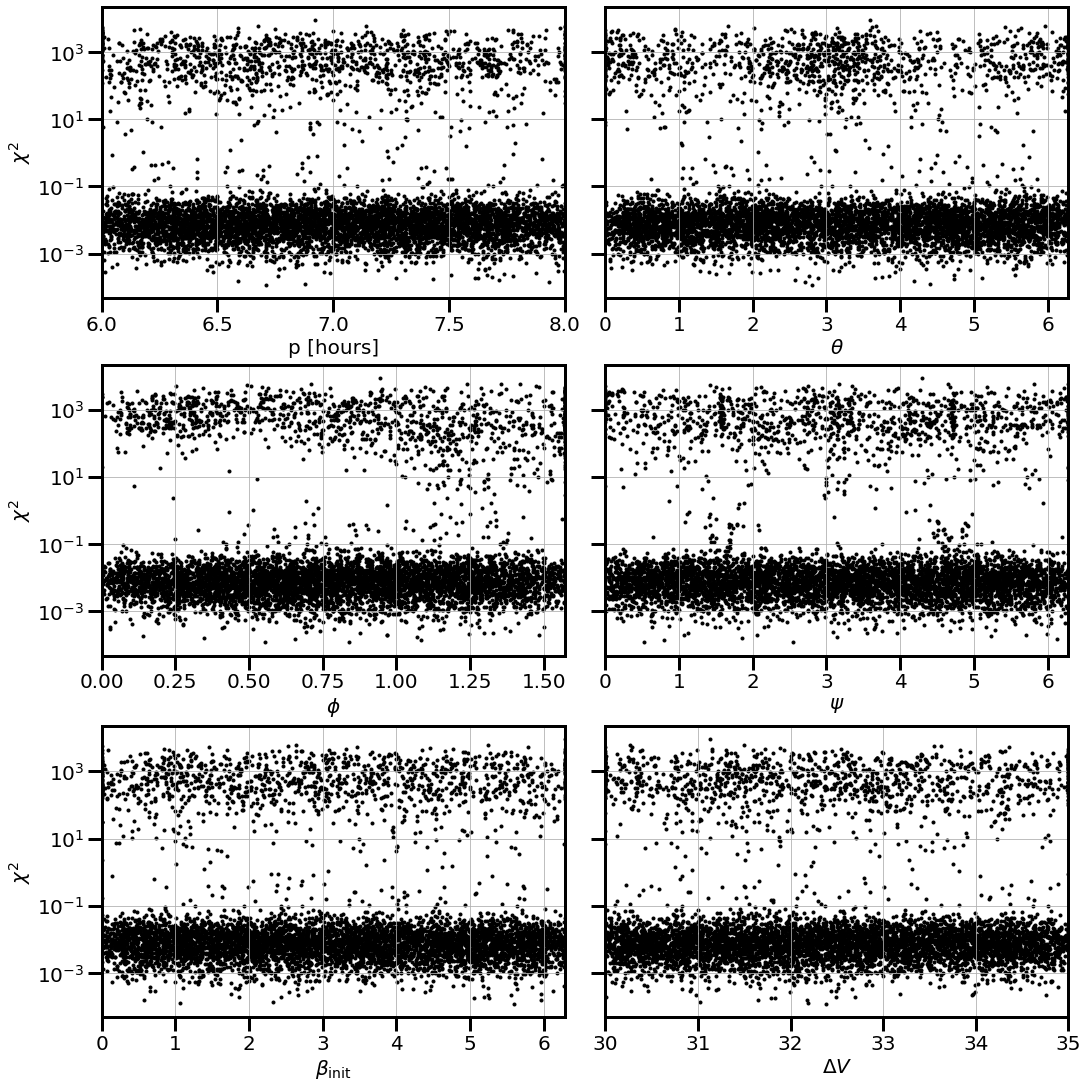

In [31]:
figx=15
figy=figx*figaspectratio

fig,axes=plt.subplots(3,2,figsize=(figx,figy),constrained_layout=True,sharey=True)

axes=axes.flatten()
opts=np.array(opts) 

labels=["p [hours]", r"$\theta$", r"$\phi$", r"$\psi$", r"$\beta_\mathrm{init}$", r"$\Delta V$"]

for i in range(6):
    axes[i].scatter(opts[:,i],chilist,color='k',marker='.')
    axes[i].set_xlabel(labels[i])
    if i%2==0:
        axes[i].set_ylabel(r"$\chi^2$")
    axes[i].set_yscale('log')
    axes[i].grid()
    
axes[0].set_xlim([6,8])
axes[1].set_xlim([0,2*np.pi])
axes[2].set_xlim([0,np.pi/2])
axes[3].set_xlim([0,2*np.pi])
axes[4].set_xlim([0,2*np.pi])
axes[5].set_xlim([30,35])

fig.set_rasterized(True)
    
plt.savefig("../Figures and Paper/validation_chi2.pdf",
           bbox_inches='tight',dpi=300)